# Predicting the Weather using Machine Learning

Data used: from GHCN (Global Historical Climatology Network)

https://www1.ncdc.noaa.gov/pub/data/cdo/documentation/GHCND_documentation.pdf



In [185]:
# Reading in the initial data

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

weather = pd.read_csv("data/local_weather.csv", index_col="DATE")


In [186]:
#Cleaning and setting up the dataframe for analysis

#Selecting specific features to look at
"""
PRCP — total precipitation
TMAX — maximum daily temperature
TMIN — minimum daily temperature
WSFG - peak guest wind speed

"""

selected_fields = ["PRCP", "TMAX", "TMIN", "WSFG"]
df = weather[selected_fields].copy()

#Renaming the columns for clarity

df.rename(columns={"PRCP": "Precipitation", "TMAX": "Max Temp (F)", "TMIN": "Min Temp (F)", "WSFG": "Peak Wind Speed"}, inplace=True)

#Checking if all data in the dataframe are numeric
df = df.apply(pd.to_numeric, errors="coerce")

# Set any 'NaN' values to the rolling mean (two rows above and below the NaN row)
rolling_mean = df.rolling(window=5, center=True).mean()
df = df.fillna(rolling_mean)

#Changing the index into a DateTime format
df.index = pd.to_datetime(df.index)

#Checking if any of the columns has the value '9999' which indicates a measurement error

if 9999 in df.values:
    print("There exists a measurement error")
else:
    print("No measurement errors present in the columns")



print(df.head())


No measurement errors present in the columns
            Precipitation  Max Temp (F)  Min Temp (F)  Peak Wind Speed
DATE                                                                  
1960-01-01            0.0          49.0          30.0              NaN
1960-01-02            0.0          49.0          29.0              NaN
1960-01-03            0.0          54.0          35.0              NaN
1960-01-04            0.0          54.0          36.0              NaN
1960-01-05            0.0          55.0          33.0              NaN


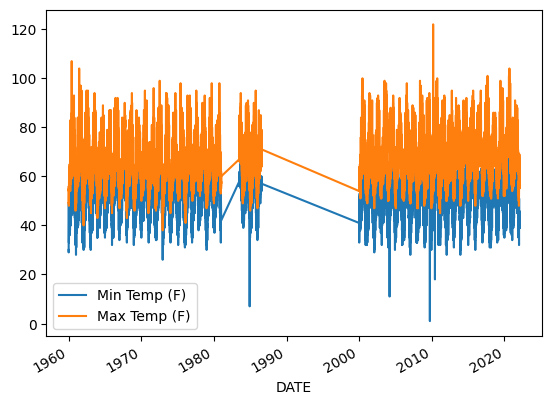

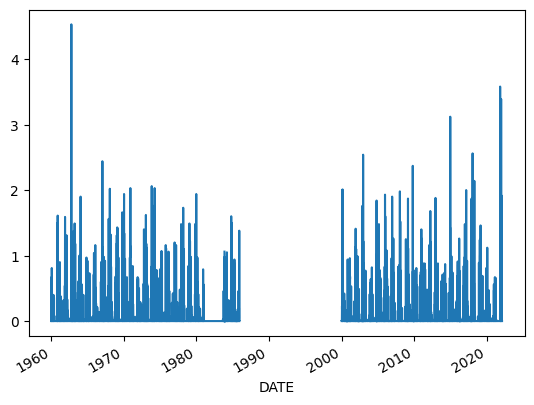

In [187]:
# Initial Data Analysis
temperatures = ["Min Temp (F)", "Max Temp (F)"]
df_temperature = df[temperatures].copy()

df_temperature.plot()
plt.show()
df["Precipitation"].plot()
plt.show()

Discontinuity between the years 1990 - 2000. This is because the data wasn't merged as since 2000 the process of collecting data has changed.

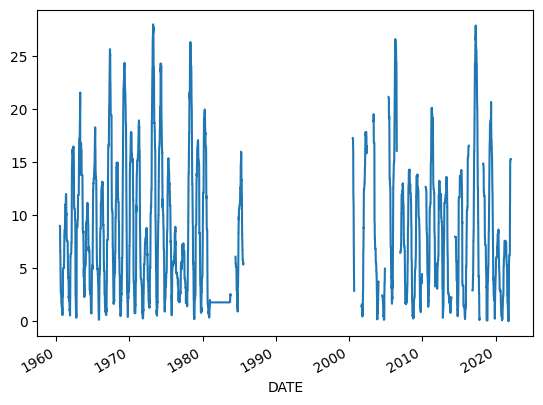

In [188]:
#Calculating the Precipitation year by year
precipitation_yearly = df["Precipitation"].rolling(window=182).sum()
precipitation_yearly.plot()
plt.show()

## Using Ridge Regression


### What is Ridge Regression?

Ridge Regression is similar to Linear Regression in which a line of best fit is derived based on the training data available through the least squares method. However, Ridge Regression introduces a small bias, which prevents the co-efficients of the line of best fit from becoming too large. This reduces the chances of "over-fitting" which is when the algorithm performs well on the training data but not as well om unseen data. Ridge Regression aims to reduce the variance by adding a penalty.


### Implementing Ridge Regression

I will use the scikit-learn library which will initialise the machine learning model. The model aims to predict the Maximum Temperature tomorrow using today's metrics. I will then plot the residual between the predicted and actual values.




Coefficients: [ 0.75 -7.19 -0.1 ] Intercept: 28.68
Mean Squared Error: 32.73020284840033


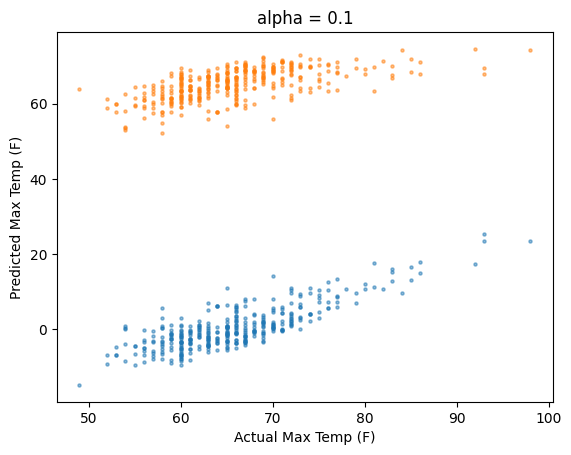

In [190]:
#Training an initial model

#Splitting the data into training and testing columns and defining predictors.

def ridge_reg_model(train, test, alpha_value, df, features):
    reg = Ridge(alpha=alpha_value)

    # Creating a Target, the next day's Maximum Temperature
    df["Target"] = df.shift(-1)["Max Temp (F)"]
    df.drop(df.tail(1).index)
    df.dropna(inplace=True)

    #reg.fit calculates the coefficients on how Maximum Temperature is affected using the training data.
    reg.fit(train[features], train["Target"])

    #Based on the co-efficients calculated previously to predict the maximum temperature on unseen data named testing_data
    predictions = reg.predict(test[features])
    mse = mean_squared_error(test["Target"], predictions)

    print("Coefficients:",reg.coef_.round(2), "Intercept:", reg.intercept_.round(2))
    print("Mean Squared Error:", mse)

    #Plotting the Actual Values and what the Model Predicted
    residuals = test["Target"] - predictions
    plt.scatter(test["Target"], residuals, s=5, alpha=0.5)
    plt.scatter(test["Target"], predictions, s=5, alpha=0.5)


    plt.title(f"alpha = {alpha_value}")
    plt.xlabel("Actual Max Temp (F)")
    plt.ylabel("Predicted Max Temp (F)")
    plt.show()

training_data = df.loc[ :"1970-12-31"]
testing_data = df.loc["1980-01-01": ]
features = ["Min Temp (F)", "Precipitation", "Peak Wind Speed"]
ridge_reg_model(training_data, testing_data, 0.1, df, features)



We can see that the vast majority of the residual points (colour coded in blue) do indeed lie within the 0 range but as the actual Maximum Temperature increases the residuals increase too.


## Improving the accuracy of our model

Coefficients: [-0.69  1.29 48.95] Intercept: -63.42
Mean Squared Error: 19.705917765549135


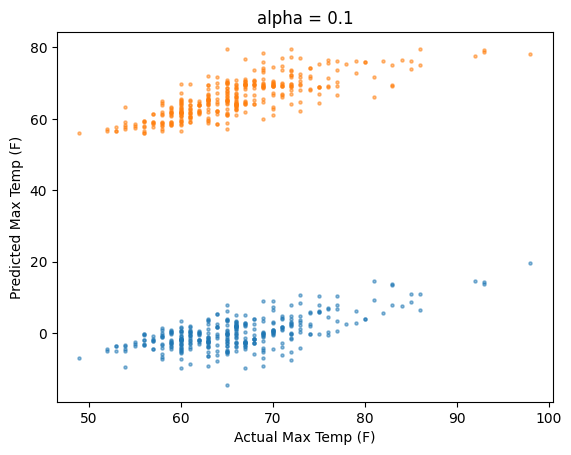

In [191]:
# Improving accuracy of our model

#Calculting the average monthly temperatures. These features may be better in avoiding anomalies.

df["Average Monthly Maximum Temperature"] = df["Max Temp (F)"].rolling(window=15, center=True).mean()
df["Average Monthly Minimum Temperature"] = df["Min Temp (F)"].rolling(window=15, center=True).mean()

df["Ratio between average monthly temperatures"] = df["Average Monthly Maximum Temperature"] / df["Average Monthly Minimum Temperature"]

df.dropna(inplace=True)

training_data = df.loc[ :"1970-12-31"]
testing_data = df.loc["1980-01-01": ]
features = ["Precipitation", "Average Monthly Minimum Temperature", "Ratio between average monthly temperatures"]

ridge_reg_model(training_data, testing_data, 0.1, df, features)





Taking the average temperature and the ratio has improved the accuracy of the model as seen with the drop in the Mean Squared Error value (32.7->28.6).